# Capstone V1 model

This is a GRU model with an untrained embedding layer.
The validation F1-score is 0.6374 at a threshold of 0.35.

In [1]:
# %load_ext memory_profiler

# Constants

In [2]:
MODEL_VERSION = 'capstoneV1'
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 300
MAX_WORDS = 50000

# Import test/train dataset

In [3]:
import numpy as np
import pandas as pd

train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = -1

## Split train/validation

In [4]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

## Fill data

In [5]:
X_train = train_df['question_text'].fillna('+++').tolist()
X_val = val_df['question_text'].fillna('+++').tolist()
X_test = test_df['question_text'].fillna('+++').tolist()

y_train = train_df['target']
y_val = val_df['target']

print('Found %s training questions.' % len(X_train))
print('Found %s validation questions.' % len(X_val))
print('Found %s test questions.' % len(X_test))

Found 1044897 training questions.
Found 261225 validation questions.
Found 56370 test questions.


In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True, split=' ', filters='',
                       char_level=False, oov_token=None, document_count=0,
                     )
                                   
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Shape of X_train: (1044897, 100)
Shape of y_train: (1044897,)
Found 392005 unique tokens.


## NN: Bidirectional GRU

In [7]:
%%time 

from keras.layers import Dense, Dropout, Input, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Bidirectional
from keras.layers import Activation, BatchNormalization, CuDNNGRU
from keras.layers import SpatialDropout1D, Concatenate, Flatten, Reshape
from keras.regularizers import l2
from keras.models import Model


inp = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
x = Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH) (inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(32)(x)
x = Activation("relu")(x)
x = Dropout(0.1)(x)
x = Dense(16)(x)
x = Activation("relu")(x)
x = Dropout(0.1)(x)
x = Dense(1)(x)
out = Activation("sigmoid")(x)

model = Model(inp, out)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

In [8]:
from keras import backend as K


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

# Compile the model

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1, recall, precision])

# serialize model

In [10]:
model.save(MODEL_VERSION + '.model.h5')
print("Saved model to disk")

Saved model to disk


# Setup f1-score, precision and recall metrics

In [11]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoints = ModelCheckpoint('capstoneV1.weights_checkpoint.h5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)

# Train the model

Use model checkpointing to save the model that attains the best validation loss.

In [12]:
%%time

hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpoints], epochs=2, batch_size=256)

Train on 1044897 samples, validate on 261225 samples
Epoch 1/2
1044897/1044897 [==============================] - 90s 86us/step - loss: 0.1260 - acc: 0.9524 - f1: 0.5241 - recall: 0.4572 - precision: 0.6522 - val_loss: 0.1092 - val_acc: 0.9570 - val_f1: 0.5824 - val_recall: 0.5141 - val_precision: 0.7007

Epoch 00001: val_f1 improved from -inf to 0.58245, saving model to capstoneV1.weights_checkpoint.h5
Epoch 2/2
1044897/1044897 [==============================] - 87s 83us/step - loss: 0.0997 - acc: 0.9603 - f1: 0.6418 - recall: 0.5948 - precision: 0.7210 - val_loss: 0.1109 - val_acc: 0.9570 - val_f1: 0.5786 - val_recall: 0.5060 - val_precision: 0.7056

Epoch 00002: val_f1 did not improve from 0.58245
CPU times: user 3min 9s, sys: 29 s, total: 3min 38s
Wall time: 2min 58s


# Predict validation labels

In [13]:
%%time

pred_val = model.predict([X_val], batch_size=1024, verbose=1)

261225/261225 [==============================] - 3s 10us/step
CPU times: user 2.68 s, sys: 504 ms, total: 3.18 s
Wall time: 2.66 s


# Find optimal threshold

In [14]:
from sklearn.metrics import f1_score, precision_score, recall_score

def optimalThreshold(y_true,y_pred):
    idx = 0
    cur_f1 = 0
    cur_prec = 0
    cur_recall = 0
    max_f1 = 0
    thres = 0
    for idx in np.arange(0.1, 0.501, 0.01):
        cur_f1 = f1_score(y_true, np.array(y_pred)> idx)
        cur_recall = recall_score(y_true, np.array(y_pred)> idx)
        cur_prec = precision_score(y_true, np.array(y_pred)> idx)
        print('Current threshold is {:.4f} with F1 score: {:.4f}, Recall score: {:.4f}, Precision score: {:.4f}'
              .format(idx, cur_f1, cur_recall, cur_prec)
             )
        if cur_f1 > max_f1:
            max_f1 = cur_f1
            thres = idx
    print('optimal threshold is {:.4f} with F1 score: {:.4f}'.format(thres, max_f1))
    return thres
threshold = optimalThreshold(y_val,pred_val)

Current threshold is 0.1000 with F1 score: 0.5724, Recall score: 0.8435, Precision score: 0.4332
Current threshold is 0.1100 with F1 score: 0.5803, Recall score: 0.8346, Precision score: 0.4448
Current threshold is 0.1200 with F1 score: 0.5868, Recall score: 0.8263, Precision score: 0.4549
Current threshold is 0.1300 with F1 score: 0.5924, Recall score: 0.8162, Precision score: 0.4650
Current threshold is 0.1400 with F1 score: 0.5974, Recall score: 0.8082, Precision score: 0.4738
Current threshold is 0.1500 with F1 score: 0.6021, Recall score: 0.7995, Precision score: 0.4828
Current threshold is 0.1600 with F1 score: 0.6069, Recall score: 0.7918, Precision score: 0.4920
Current threshold is 0.1700 with F1 score: 0.6115, Recall score: 0.7841, Precision score: 0.5012
Current threshold is 0.1800 with F1 score: 0.6161, Recall score: 0.7771, Precision score: 0.5104
Current threshold is 0.1900 with F1 score: 0.6206, Recall score: 0.7697, Precision score: 0.5198
Current threshold is 0.2000 wi

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_val, np.array(pred_val > threshold).astype(int), target_names=['sincere', 'insincere']))


              precision    recall  f1-score   support

     sincere       0.98      0.97      0.97    245369
   insincere       0.59      0.69      0.64     15856

   micro avg       0.95      0.95      0.95    261225
   macro avg       0.79      0.83      0.81    261225
weighted avg       0.96      0.95      0.95    261225



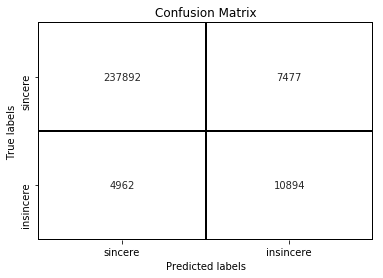

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cm = confusion_matrix(y_val, np.array(pred_val > threshold).astype(int))
ax = plt.subplot()
hm = sns.heatmap(cm, annot=True, ax = ax, fmt='g', 
                 cmap=ListedColormap(['white']), linecolor='black', 
                 linewidth=1, cbar=False,
                 xticklabels = 1, yticklabels = 1 )


# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['sincere', 'insincere'])
ax.yaxis.set_ticklabels(['sincere', 'insincere'])
plt.show()

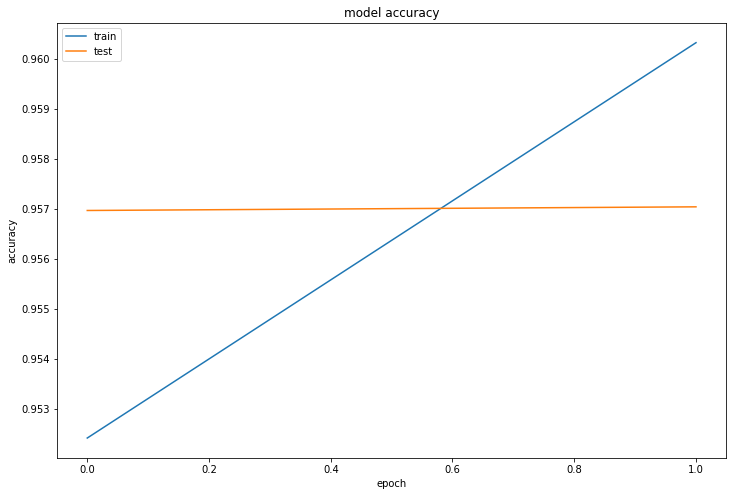

In [17]:
plt.figure(figsize=(12,8))
plt.title('model accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

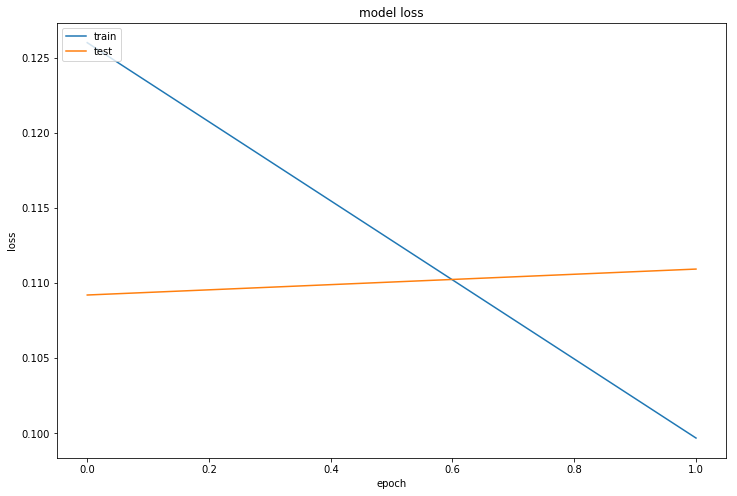

In [18]:
plt.figure(figsize=(12,8))
plt.title('model loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

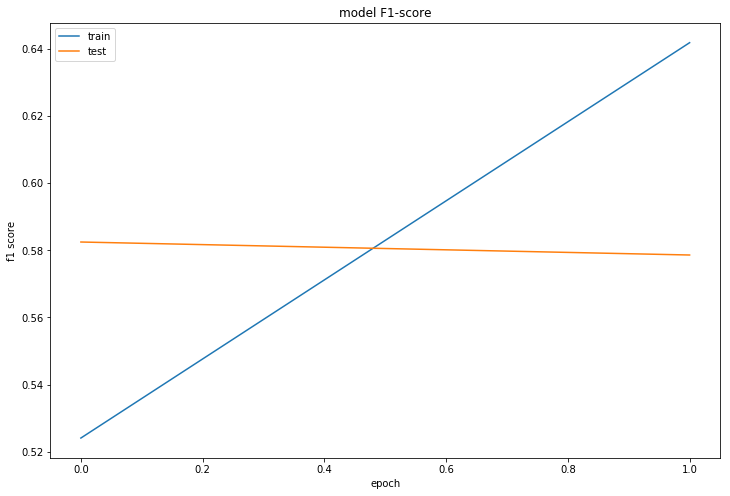

In [19]:
plt.figure(figsize=(12,8))
plt.title('model F1-score')
plt.plot(hist.history['f1'])
plt.plot(hist.history['val_f1'])
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# serialize weights

In [20]:
model.save_weights(MODEL_VERSION + '.weights.h5')
print("Saved model weights to disk")

Saved model weights to disk


# Predict test labels

In [21]:
%%time

pred_test = model.predict([X_test], batch_size=1024, verbose=1)

56370/56370 [==============================] - 1s 10us/step
CPU times: user 524 ms, sys: 156 ms, total: 680 ms
Wall time: 572 ms


# Analyze predictions

In [22]:
prediction_df = pd.DataFrame({"qid":test_df["qid"].values})
prediction_df['prediction'] = (pred_test > threshold).astype(int)

In [23]:
type(hist)

keras.callbacks.History

In [24]:
import pickle


pickle_out = open(MODEL_VERSION + '.hist.pkl',"wb")
pickle.dump(hist, pickle_out)
pickle_out.close()